In [ ]:
import os
import shutil
import time

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

In [ ]:
# https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
data_dir = "/kaggle/input/animal-image-classification-dataset/Animals"
output_dir = "/kaggle/working/" 

os.makedirs(f"{output_dir}/train", exist_ok=True)
os.makedirs(f"{output_dir}/val", exist_ok=True)

In [3]:
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        file_paths = [os.path.join(class_path, fname) for fname in os.listdir(class_path)]
        
        train_files, val_files = train_test_split(file_paths, train_size=0.8, random_state=42)
        
        os.makedirs(f"{output_dir}/train/{class_name}", exist_ok=True)
        os.makedirs(f"{output_dir}/val/{class_name}", exist_ok=True)
        
        for file in train_files:
            shutil.copy(file, f"{output_dir}/train/{class_name}")
        for file in val_files:
            shutil.copy(file, f"{output_dir}/val/{class_name}")
            
print("Данные успешно разделены!")

Данные успешно разделены!


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(root=f"{output_dir}/{x}", transform=data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
model = models.resnet50(pretrained=True)

num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [30]:
def calculate_f1(dataloader, model):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return f1_score(all_labels, all_preds, average='weighted')

In [31]:
def plot_confusion_matrix(dataloader, model, class_names):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                epoch_f1 = calculate_f1(dataloaders[phase], model)
                print(f'{phase} F1-Score: {epoch_f1:.4f}')

                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1-Score: {best_f1:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [37]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=15)


Epoch 0/14
----------
train Loss: 0.5328 Acc: 0.8013
val Loss: 0.6191 Acc: 0.7633
val F1-Score: 0.7459

Epoch 1/14
----------
train Loss: 0.3215 Acc: 0.8679
val Loss: 0.3906 Acc: 0.8500
val F1-Score: 0.8512

Epoch 2/14
----------
train Loss: 0.2242 Acc: 0.9167
val Loss: 0.6058 Acc: 0.7917
val F1-Score: 0.7877

Epoch 3/14
----------
train Loss: 0.2538 Acc: 0.9117
val Loss: 0.3539 Acc: 0.8833
val F1-Score: 0.8825

Epoch 4/14
----------
train Loss: 0.1571 Acc: 0.9421
val Loss: 0.3316 Acc: 0.8750
val F1-Score: 0.8757

Epoch 5/14
----------
train Loss: 0.1685 Acc: 0.9400
val Loss: 0.4060 Acc: 0.8517
val F1-Score: 0.8476

Epoch 6/14
----------
train Loss: 0.1339 Acc: 0.9517
val Loss: 0.3076 Acc: 0.9067
val F1-Score: 0.9060

Epoch 7/14
----------
train Loss: 0.0636 Acc: 0.9796
val Loss: 0.1266 Acc: 0.9567
val F1-Score: 0.9565

Epoch 8/14
----------
train Loss: 0.0342 Acc: 0.9896
val Loss: 0.1335 Acc: 0.9483
val F1-Score: 0.9481

Epoch 9/14
----------
train Loss: 0.0192 Acc: 0.9971
val Loss: 

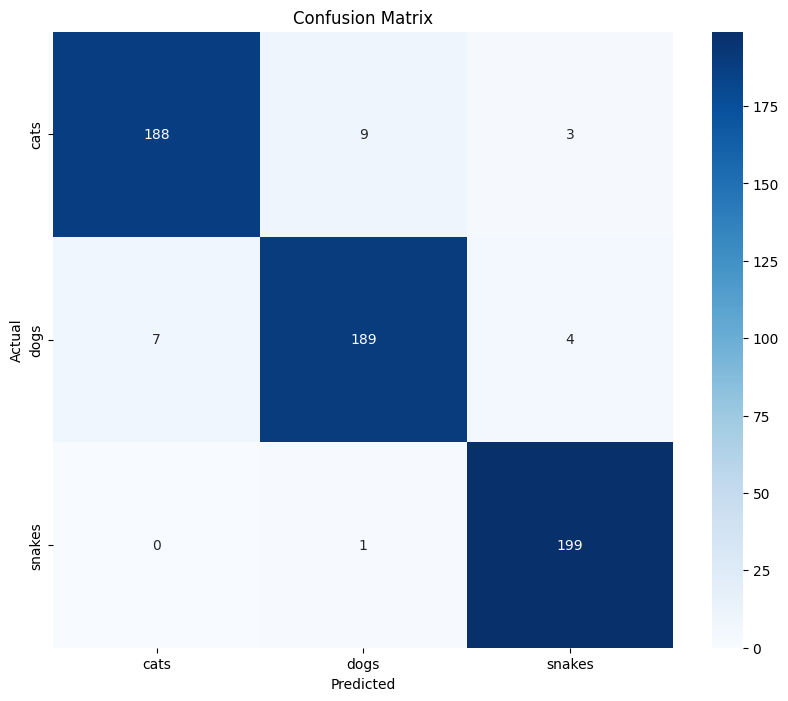

In [38]:
plot_confusion_matrix(dataloaders['val'], model, class_names)